In [6]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import corner
import json

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op
from pytensor.tensor.type import TensorType

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('jax')
# pyhf.set_backend('numpy')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import actual_inference
from pyhf_pymc import slow_inference

## Model

In [2]:
N = 5
nBins = N
obs = jnp.array([70., 70., 90., 90., 80.])
model = pyhf.simplemodels.correlated_background([10]*N,[50]*N,[45]*N,[55]*N)
model.expected_actualdata(model.config.suggested_init()),model.config.suggested_init()

n_samples = 1000

unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[5.], [1.]]}
}
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
precision = []
[precision.append(float(obs[i])**(0.5)) for i in range(nBins)]
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, precision=precision, priors=prior_dict)

In [3]:
N = 5
nBins = N
obs = jnp.array([100., 170., 190., 190., 180.])

model = pyhf.simplemodels.uncorrelated_background(
    signal=[5., 5., 5., 5., 5.], bkg=[50., 60., 65., 65., 65.], bkg_uncertainty=[3.0, 7.0, 3.0, 7.0, 3.0]
)

n_samples = 1000

unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[5.], [1.]]}
}
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
precision = []
[precision.append(float(obs[i])**(0.5)) for i in range(nBins)]
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, precision=precision, priors=prior_dict)

In [7]:
# with open('SRee_SRmm_Srem.json') as serialized:
with open('ttbar_ljets_xsec_inclusive_pruned.json') as serialized:
    spec = json.load(serialized)

workspace = pyhf.Workspace(spec)
model = workspace.model()

obs = workspace.data(model, include_auxdata=False)

nBins = len(model.expected_actualdata(model.config.suggested_init()))
nPars = len(model.config.suggested_init())

# Prepare the priors for sampling
    # Unconstrained parameters
unconstr_dict = {
    'uncon1': {'type': 'unconstrained', 'type2': 'normal', 'input': [[2], [1]]}
    }

    # Create dictionary with all priors (unconstrained, constrained by normal and poisson)
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)

    # dictionary with keys 'model', 'obs', 'priors', 'precision'
precision = []
[precision.append(float(obs[i])**(0.5)) for i in range(nBins)]
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, precision=precision, priors=prior_dict)

## Use `actual_inference.py`

- instantiate Op before
- choose either `step_method` = 'NUTS_with_jitter', 'NUTS_with_advi' or 'Metropolis'

In [8]:
expData_op = actual_inference.make_op(model)

In [9]:
post_data, post_pred, prior_pred = actual_inference.sampling(prepared_model, expData_op, draws=1000, n_chains=1, tune=10, step_method='NUTS_with_advi', )

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 71900
Interrupted at 71,899 [35%]: Average Loss = 4.4184e+09
Interrupted at 71,899 [35%]: Average Loss = 4.4184e+09


Sampling 1 chain for 10 tune and 1_000 draw iterations (10 + 1_000 draws total) took 454 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


## Plotting

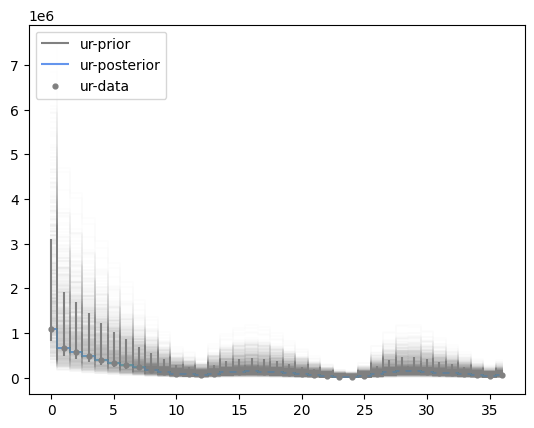

In [5]:
# ur Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.Expected_Data[0].T, alpha = 0.01, c = 'grey', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = 'grey', label='ur-prior');

# ur Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.Expected_Data[0].T, alpha = 0.01, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = 'cornflowerblue', label='ur-posterior')

# Observations
plt.scatter(np.arange(nBins), obs, c = 'grey', s=12, zorder = 999, label = "ur-data")

plt.legend(loc='upper left')

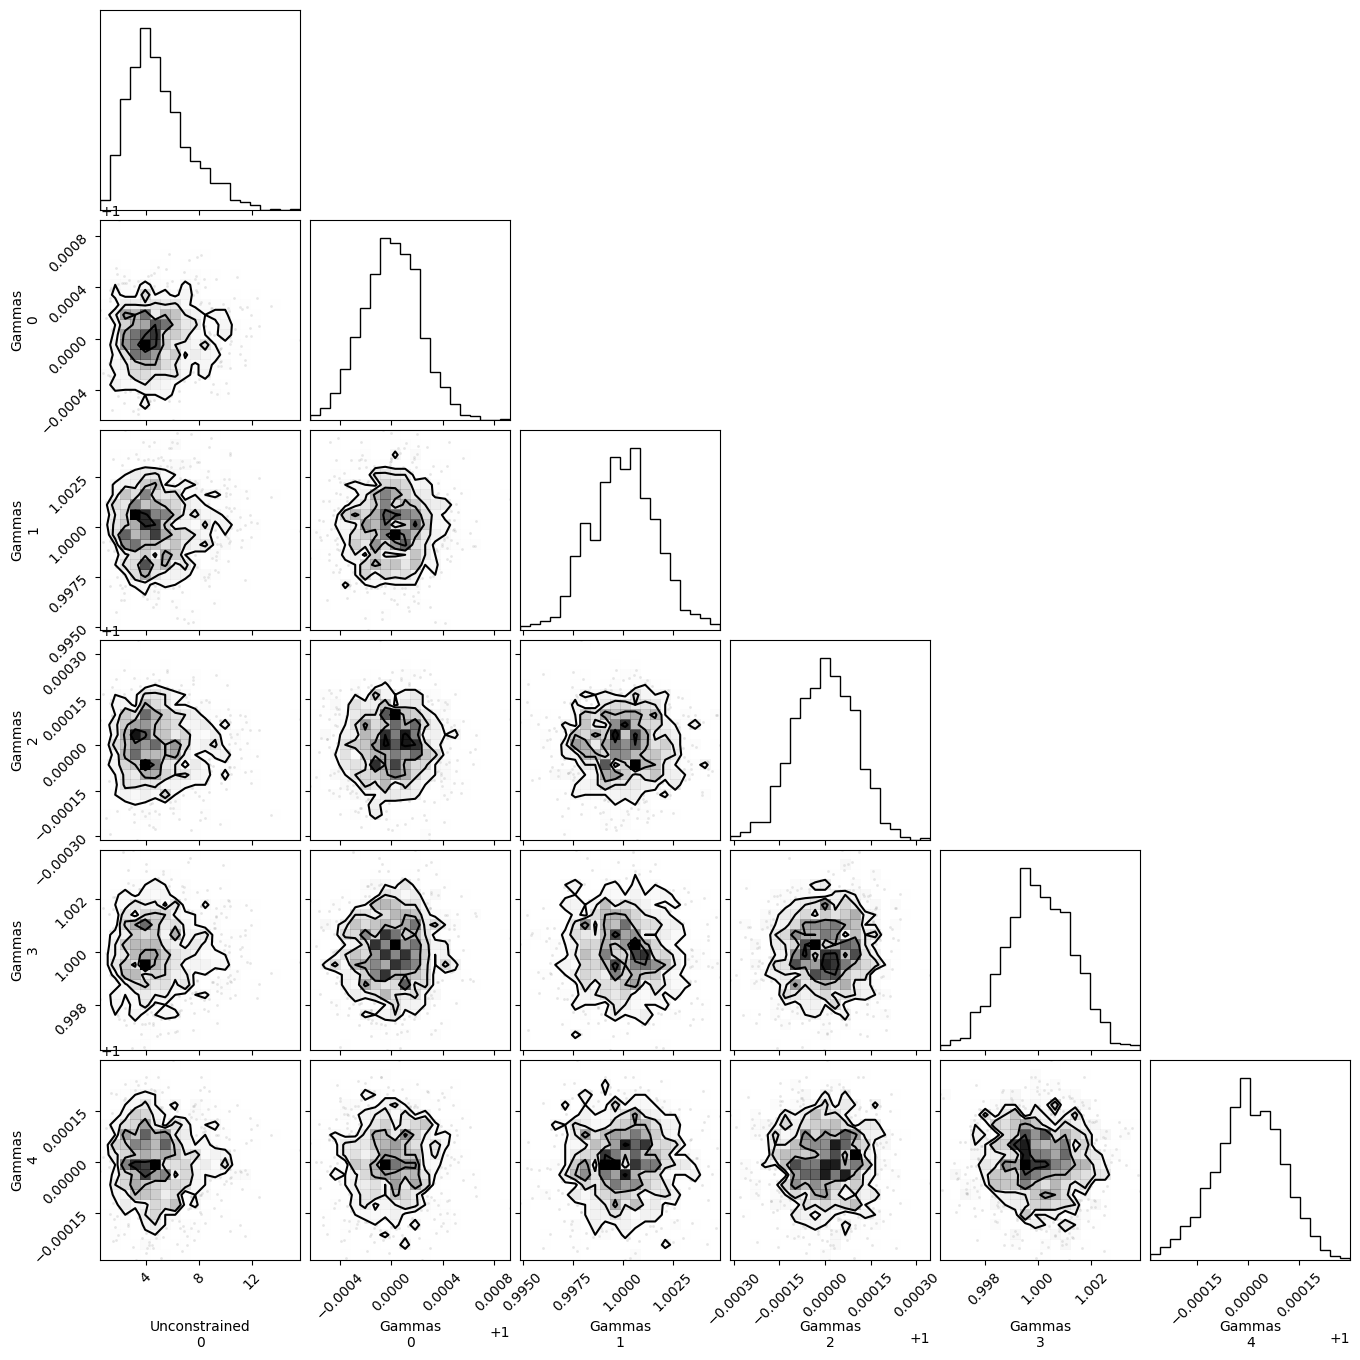

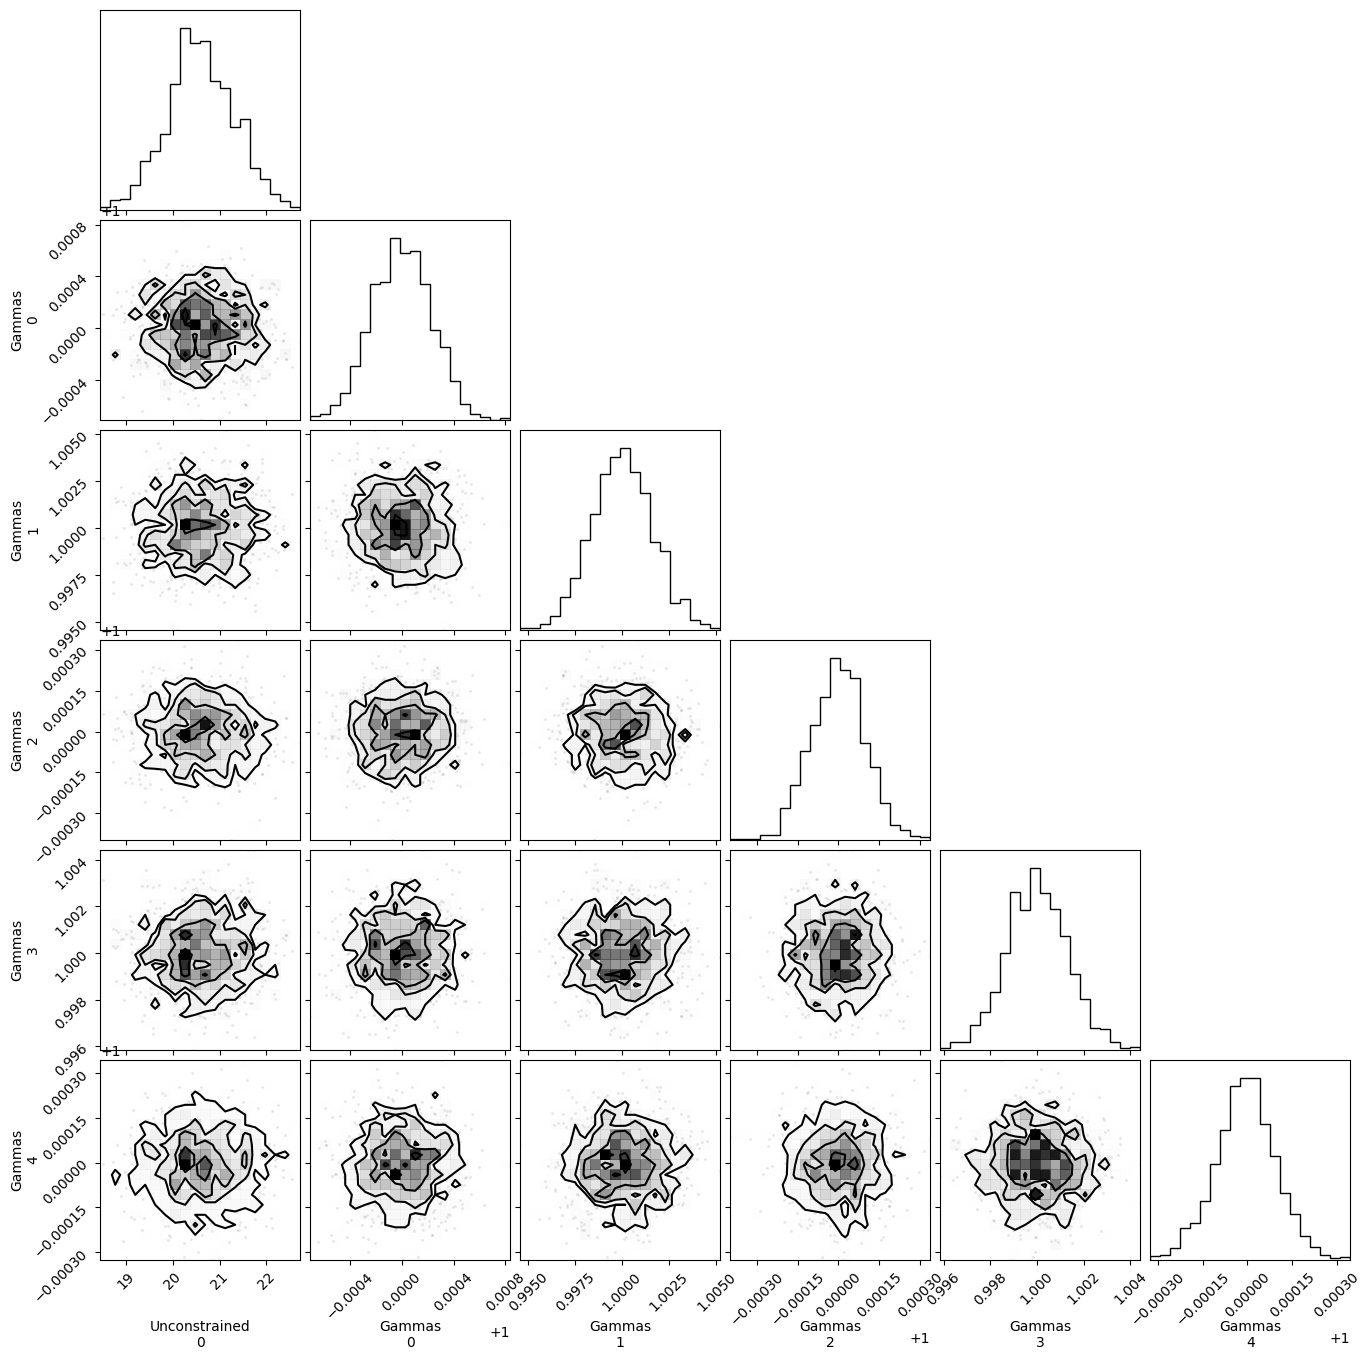

In [22]:
a = corner.corner(prior_pred.prior)
b = corner.corner(post_data.posterior)